# Test imputation on untyped SNPs chrom 18

In [1]:
using Revise
using VCFTools
using MendelImpute
using GeneticVariation
using Random
using StatsBase
using CodecZlib
using ProgressMeter
using JLD2, FileIO, JLSO
using BenchmarkTools
using GroupSlices
using TimerOutputs
using LinearAlgebra
using ThreadPools
# using ProfileView

┌ Info: Precompiling MendelImpute [e47305d1-6a61-5370-bc5d-77554d143183]
└ @ Base loading.jl:1273


### Memory requirement

**Prephasing step:** 
+ Target data requies $people * snps * 4$ bytes of RAM
+ Reference haplotype data requires $haplotypes * snps$ bits of RAM
+ Redundant haplotype set for imputation target requires roughly
$people * windows * 1000$ (max haplotypes per win) $* 16 bytes$ of RAM

## Generate subset of markers for prephasing

In [3]:
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function filter_and_mask()
    for chr in [18]
        # filter chromosome data for unique snps
        data = "../beagle_raw/chr$chr.1kg.phase3.v5a.vcf.gz"
        full_record_index = .!find_duplicate_marker(data)
        @time VCFTools.filter(data, full_record_index, 1:nsamples(data), 
            des = "chr$chr.uniqueSNPs.vcf.gz")

        # summarize data
        total_snps, samples, _, _, _, maf_by_record, _ = gtstats("chr$chr.uniqueSNPs.vcf.gz")

        # generate target panel with all snps
        n = 100
        sample_idx = falses(samples)
        sample_idx[1:n] .= true
        shuffle!(sample_idx)
        @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
            sample_idx, des = "target.chr$chr.full.vcf.gz", allow_multiallelic=false)

        # also generate reference panel without target samples
        @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", 1:total_snps, 
            .!sample_idx, des = "ref.chr$chr.excludeTarget.vcf.gz", allow_multiallelic=false)
        
        for maf in [0.0005, 0.001, 0.01, 0.1, 0.45]
            
            # generate target file with 100 samples and typed snps with certain maf
            my_maf = findall(x -> x > maf, maf_by_record)  
            p = length(my_maf)
            record_idx = falses(total_snps)
            record_idx[my_maf] .= true
            @time VCFTools.filter("chr$chr.uniqueSNPs.vcf.gz", record_idx, sample_idx, 
                des = "target.chr$chr.typedOnly.maf$maf.vcf.gz", allow_multiallelic=false)

            # unphase and mask 1% entries in target file
            masks = falses(p, n)
            missingprop = 0.001
            for j in 1:n, i in 1:p
                rand() < missingprop && (masks[i, j] = true)
            end
            @time mask_gt("target.chr$chr.typedOnly.maf$maf.vcf.gz", masks, 
                des="target.chr$chr.typedOnly.maf$maf.masked.vcf.gz", unphase=true)
        end
    end 
end
Random.seed!(2020)
@time filter_and_mask()

752.076342 seconds (6.51 G allocations: 615.353 GiB, 7.01% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:08:17


549.100648 seconds (6.86 G allocations: 650.723 GiB, 10.18% gc time)
1139.017251 seconds (16.68 G allocations: 1.249 TiB, 10.94% gc time)
599.893049 seconds (6.86 G allocations: 650.911 GiB, 10.61% gc time)
 36.158916 seconds (267.39 M allocations: 27.452 GiB, 6.96% gc time)
608.676819 seconds (6.83 G allocations: 648.780 GiB, 10.30% gc time)
 35.610763 seconds (249.89 M allocations: 25.655 GiB, 6.86% gc time)
560.687780 seconds (6.61 G allocations: 626.620 GiB, 10.27% gc time)
 16.352906 seconds (119.38 M allocations: 12.252 GiB, 6.40% gc time)
520.047088 seconds (6.51 G allocations: 615.447 GiB, 10.21% gc time)
  8.014085 seconds (53.29 M allocations: 5.482 GiB, 5.36% gc time)
516.890704 seconds (6.43 G allocations: 607.361 GiB, 10.60% gc time)
  0.831218 seconds (5.35 M allocations: 563.018 MiB, 5.66% gc time)
6410.931663 seconds (76.92 G allocations: 6.823 TiB, 10.06% gc time)


In [2]:
@show nrecords("ref.chr18.excludeTarget.vcf.gz")

nrecords("ref.chr18.excludeTarget.vcf.gz") = 852602


852602

In [3]:
@show nrecords("target.chr18.typedOnly.maf0.1.masked.vcf.gz")

nrecords("target.chr18.typedOnly.maf0.1.masked.vcf.gz") = 169914


169914

# Try jlso compression

In [2]:
widths = [64, 128, 256, 512, 1024, 2048]
mafs = [0.1]

reffile = "ref.chr18.excludeTarget.vcf.gz"
H, H_sampleID, H_chr, H_pos, H_ids, H_ref, H_alt = convert_ht(Bool, reffile, trans=true, save_snp_info=true, msg="importing reference data...")

for maf in mafs
    tgtfile = "target.chr18.typedOnly.maf$maf.masked.vcf.gz"
    X, X_sampleID, X_chr, X_pos, X_ids, X_ref, X_alt = VCFTools.convert_gt(UInt8, tgtfile, trans=true, save_snp_info=true, msg = "Importing genotype file...")
    Threads.@threads for width in widths
        outfile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
        @time compress_haplotypes(H, X, outfile, X_pos, H_sampleID, H_chr, H_pos, H_ids, H_ref, H_alt, width)
    end
end

importing reference data...100%|████████████████████████| Time: 0:04:46


196.849193 seconds (70.70 M allocations: 142.717 GiB, 21.96% gc time)
251.230231 seconds (81.94 M allocations: 172.259 GiB, 23.75% gc time)
320.946634 seconds (95.82 M allocations: 217.223 GiB, 26.01% gc time)
401.944631 seconds (110.72 M allocations: 273.113 GiB, 27.29% gc time)
466.901246 seconds (123.60 M allocations: 321.061 GiB, 25.81% gc time)
579.757844 seconds (133.52 M allocations: 368.549 GiB, 22.00% gc time)


In [3]:
;ls -al ref.chr18.excludeTarget.vcf.gz

-rw-r--r--@ 1 biona001  staff  247072174 May 19 23:43 ref.chr18.excludeTarget.vcf.gz


In [2]:
;ls -al ref.chr18.2048.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  179998505 Jun 28 23:18 ref.chr18.2048.maf0.1.excludeTarget.jlso


In [3]:
;ls -al ref.chr18.1024.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  145501023 Jun 28 23:18 ref.chr18.1024.maf0.1.excludeTarget.jlso


In [4]:
;ls -al ref.chr18.512.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  121963667 Jun 28 23:20 ref.chr18.512.maf0.1.excludeTarget.jlso


In [5]:
;ls -al ref.chr18.256.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  109057750 Jun 28 23:21 ref.chr18.256.maf0.1.excludeTarget.jlso


In [6]:
;ls -al ref.chr18.128.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  112634329 Jun 28 23:22 ref.chr18.128.maf0.1.excludeTarget.jlso


In [7]:
;ls -al ref.chr18.64.maf0.1.excludeTarget.jlso

-rw-r--r--  1 biona001  staff  139308490 Jun 28 23:24 ref.chr18.64.maf0.1.excludeTarget.jlso


In [4]:
reffile = "ref.chr18.64.maf0.1.excludeTarget.jlso"
@time loaded = JLSO.load(reffile)
compressed_Hunique = loaded[:compressed_Hunique];

 13.660642 seconds (17.95 M allocations: 1.455 GiB, 11.49% gc time)


# MendelImpute error rate and timing

In [8]:
Threads.nthreads()

8

In [11]:
# 8 threads, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:06
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.6795 seconds
    Computing haplotype pair        = 66.8235 seconds
        BLAS3 mul! to get M and N      = 8.81538 seconds per thread
        haplopair search               = 43.7844 seconds per thread
        supplying constant terms       = 0.00405961 seconds per thread
        finding redundant happairs     = 0.0471254 seconds per thread
    Phasing by dynamic programming  = 0.325226 seconds
    Imputation                      = 9.08613 seconds

 87.094466 seconds (53.87 M allocations: 29.474 GiB, 6.25% gc time)
error overall = 0.006451474427693109 



# MendelImpute with intersecting win-by-win

In [12]:
# 8 threads, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:04
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 10.2169 seconds
    Computing haplotype pair        = 64.3885 seconds
        BLAS3 mul! to get M and N      = 8.1885 seconds per thread
        haplopair search               = 44.4355 seconds per thread
        supplying constant terms       = 0.00707497 seconds per thread
        finding redundant happairs     = 0.0401151 seconds per thread
    Phasing by dynamic programming  = 1.45939 seconds
    Imputation                      = 9.32828 seconds

 85.419115 seconds (54.16 M allocations: 29.263 GiB, 6.20% gc time)
error overall = 0.006448612600017359 



In [ ]:
# 8 threads, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@profview phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false)
@profview phase(tgtfile, reffile, outfile=outfile, impute=true, width=width,
    dynamic_programming = false)

Importing genotype file...100%|█████████████████████████| Time: 0:00:22
Computing optimal haplotype pairs...100%|███████████████| Time: 0:03:13
Writing to file...100%|█████████████████████████████████| Time: 0:00:21


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 44.9006 seconds
    Computing haplotype pair        = 193.105 seconds
        BLAS3 mul! to get M and N      = 22.1224 seconds per thread
        haplopair search               = 116.876 seconds per thread
        supplying constant terms       = 0.00661955 seconds per thread
        finding redundant happairs     = 0.0678014 seconds per thread
    Phasing by dynamic programming  = 0.664613 seconds
    Imputation                      = 28.7669 seconds



Importing genotype file...100%|█████████████████████████| Time: 0:00:06
Computing optimal haplotype pairs...100%|███████████████| Time: 0:02:43
Writing to file...100%|█████████████████████████████████| Time: 0:00:20


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 17.9547 seconds
    Computing haplotype pair        = 163.077 seconds
        BLAS3 mul! to get M and N      = 20.0341 seconds per thread
        haplopair search               = 106.989 seconds per thread
        supplying constant terms       = 0.00696271 seconds per thread
        finding redundant happairs     = 0.042082 seconds per thread
    Phasing by dynamic programming  = 0.54587 seconds
    Imputation                      = 27.0476 seconds



In [2]:
using Profile
Profile.init()
Profile.init(n = 10^8, delay = 0.1)

# Haplotype rescreening

This is enabled by the "rescreen" option. This option saves a number of top haplotype pairs when solving the least squares objective, and re-minimize least squares on just observed data.

In [2]:
# 8 threads, keep best happair
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, rescreen=true)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:41
Writing to file...100%|█████████████████████████████████| Time: 0:00:05


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 11.6378 seconds
    Computing haplotype pair        = 101.625 seconds
        BLAS3 mul! to get M and N      = 7.01822 seconds per thread
        haplopair search               = 70.7799 seconds per thread
        min least sq on observed data  = 3.98029 seconds per thread
        finding redundant happairs     = 0.136863 seconds per thread
    Phasing by dynamic programming  = 1.21521 seconds
    Imputation                      = 8.14599 seconds

146.477979 seconds (133.17 M allocations: 33.788 GiB, 4.81% gc time)
error overall = 0.006390132793495675 



# Haplotype Thinning

This is enabled by setting "thinning_factor" to some constant. This option solves the least squares objective on only "thining_factor" unique haplotypes.

In [2]:
Threads.nthreads()

8

In [ ]:
# 8 threads, hamming, search top 100 unique haplotypes per window
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)

for tf in 1000:1000:10000
    @time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
        thinning_factor=tf)
    X_mendel = convert_gt(UInt8, outfile)
    println("tf = $tf has error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")
end

Computing optimal haplotype pairs...100%|███████████████| Time: 0:02:00
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 12.2596 seconds
    Computing haplotype pair        = 120.687 seconds
        BLAS3 mul! to get M and N      = 104.648 seconds per thread
        haplopair search               = 9.75904 seconds per thread
        supplying constant terms       = 0.00472239 seconds per thread
        finding redundant happairs     = 0.0766924 seconds per thread
    Phasing by dynamic programming  = 1.84139 seconds
    Imputation                      = 8.78157 seconds

165.328130 seconds (134.17 M allocations: 14.083 GiB, 2.07% gc time)
tf = 1000 has error overall = 0.007559271500653294 



Computing optimal haplotype pairs...100%|███████████████| Time: 0:07:38
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 8.54352 seconds
    Computing haplotype pair        = 458.694 seconds
        BLAS3 mul! to get M and N      = 408.609 seconds per thread
        haplopair search               = 41.9788 seconds per thread
        supplying constant terms       = 0.00921871 seconds per thread
        finding redundant happairs     = 0.0171454 seconds per thread
    Phasing by dynamic programming  = 1.30773 seconds
    Imputation                      = 8.22815 seconds

476.772088 seconds (54.03 M allocations: 14.333 GiB, 0.68% gc time)
tf = 2000 has error overall = 0.0066489288085179255 



Computing optimal haplotype pairs...  3%|▍              |  ETA: 0:24:25

In [4]:
# haplopair_thin2 (BLAS 3 once), 8 threads
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=1000)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:29
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 8.48482 seconds
    Computing haplotype pair        = 89.3096 seconds
        BLAS3 mul! to get M and N      = 9.9904 seconds per thread
        haplopair search               = 65.2954 seconds per thread
        supplying constant terms       = 0.00567768 seconds per thread
        finding redundant happairs     = 0.0338238 seconds per thread
    Phasing by dynamic programming  = 0.347972 seconds
    Imputation                      = 9.06903 seconds

107.378400 seconds (64.80 M allocations: 30.578 GiB, 5.23% gc time)
error overall = 0.007559623364711788 



In [5]:
# haplopair_thin2 (BLAS 3 once), 8 threads
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=5000)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:21
Writing to file...100%|█████████████████████████████████| Time: 0:00:07


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 9.65899 seconds
    Computing haplotype pair        = 81.0953 seconds
        BLAS3 mul! to get M and N      = 8.85998 seconds per thread
        haplopair search               = 54.2389 seconds per thread
        supplying constant terms       = 0.0209175 seconds per thread
        finding redundant happairs     = 0.0697193 seconds per thread
    Phasing by dynamic programming  = 0.363853 seconds
    Imputation                      = 10.521 seconds

101.638958 seconds (52.35 M allocations: 29.399 GiB, 5.28% gc time)
error overall = 0.006451474427693109 



In [2]:
# haplopair_thin2 (BLAS 3 once), 8 threads
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"
outfile = "mendel.imputed.dp$width.maf$maf.vcf.gz"
@time ph, hs = phase(tgtfile, reffile, outfile=outfile, impute=true, width=width, 
    thinning_factor=10000)

X_complete = convert_gt(UInt8, "target.chr18.full.vcf.gz")
n, p = size(X_complete)
X_mendel = convert_gt(UInt8, outfile)
println("error overall = $(sum(X_mendel .!= X_complete) / n / p) \n")

Computing optimal haplotype pairs...100%|███████████████| Time: 0:28:39
Writing to file...100%|█████████████████████████████████| Time: 0:00:06


Total windows = 331, averaging ~ 4096 unique haplotypes per window.

Timings: 
    Data import                     = 12.0589 seconds
    Computing haplotype pair        = 1720.12 seconds
        BLAS3 mul! to get M and N      = 10.1659 seconds per thread
        haplopair search               = 1508.7 seconds per thread
        supplying constant terms       = 0.0079014 seconds per thread
        finding redundant happairs     = 0.0411627 seconds per thread
    Phasing by dynamic programming  = 1.06579 seconds
    Imputation                      = 9.33702 seconds

1763.580177 seconds (147.81 M allocations: 34.750 GiB, 0.42% gc time)
error overall = 0.006457268455856308 



# Beagle 5.0

In [3]:
# beagle 5
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function beagle()
    chr = 18
    for maf in [0.0005, 0.001, 0.01, 0.1, 0.45]
        tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
        reffile = "ref.chr$chr.excludeTarget.vcf.gz"
        outfile = "beagle.imputed.maf$maf"
        Base.run(`java -Xmx15g -jar beagle.28Sep18.793.jar gt=$tgtfile ref=$reffile out=$outfile nthreads=4`)
    end
end
beagle()

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 10:09 AM PDT on 08 May 2020

Command line: java -Xmx13653m -jar beagle.28Sep18.793.jar
  gt=target.chr18.typedOnly.maf0.0005.masked.vcf.gz
  ref=ref.chr18.excludeTarget.vcf.gz
  out=beagle.imputed.maf0.0005
  nthreads=4

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       2,404
Study samples:             100

Window 1 (18:10644-40010629)
Reference markers:     414,911
Study markers:         414,911

Burnin  iteration 1:           48 seconds
Burnin  iteration 2:           1 minute 28 seconds
Burnin  iteration 3:           1 minute 42 seconds
Burnin  iteration 4:           1 minute 46 seconds
Burnin  iteration 5:           1 minute 53 seconds
Burnin  iteration 6:           2 minutes 5 seconds

Phasing iteration 1:           1 minute 59 seconds
Phasing iteration 2:           2 minutes 1 second
Phasing iterati

DimensionMismatch: DimensionMismatch("arrays could not be broadcast to a common size; got a dimension with lengths 678557 and 863592")

In [5]:
for maf in [0.0005]
    # beagle error rate    
    chr = 18
    X_complete = convert_gt(UInt8, "target.chr$chr.full.vcf.gz")
    X_beagle = convert_gt(UInt8, "beagle.imputed.maf$maf.vcf.gz")
    n, p = size(X_complete)
    println("error overall = $(sum(X_beagle .!= X_complete) / n / p) \n")
end

error overall = 5.453964372064586e-6 



In [1]:
# beagle 5
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function beagle()
    chr = 18
    for maf in [0.001, 0.01, 0.1, 0.45]
        tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
        reffile = "ref.chr$chr.excludeTarget.vcf.gz"
        outfile = "beagle.imputed.maf$maf"
        Base.run(`java -Xmx15g -jar beagle.28Sep18.793.jar gt=$tgtfile ref=$reffile out=$outfile nthreads=4`)
    end
end
beagle()

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 02:52 PM PDT on 12 May 2020

Command line: java -Xmx13653m -jar beagle.28Sep18.793.jar
  gt=target.chr18.typedOnly.maf0.001.masked.vcf.gz
  ref=ref.chr18.excludeTarget.vcf.gz
  out=beagle.imputed.maf0.001
  nthreads=4

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       2,404
Study samples:             100

Window 1 (18:10644-40010629)
Reference markers:     414,911
Study markers:         388,114

Burnin  iteration 1:           38 seconds
Burnin  iteration 2:           1 minute 26 seconds
Burnin  iteration 3:           1 minute 28 seconds
Burnin  iteration 4:           1 minute 35 seconds
Burnin  iteration 5:           1 minute 50 seconds
Burnin  iteration 6:           1 minute 47 seconds

Phasing iteration 1:           1 minute 43 seconds
Phasing iteration 2:           1 minute 47 seconds
Phasing iteratio

UndefVarError: UndefVarError: convert_gt not defined

In [3]:
# beagle error rate    
chr = 18
X_complete = convert_gt(UInt8, "target.chr$chr.full.vcf.gz")
X_beagle = convert_gt(UInt8, "beagle.imputed.maf0.001.vcf.gz")
n, p = size(X_complete)
println("error overall = $(sum(X_beagle .!= X_complete) / n / p) \n")

ErrorException: GeneticVariation.VCF.Reader file format error on line 11 ~>"�;IMP\t"

In [7]:
# beagle 5
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function beagle()
    chr = 18
    for maf in [0.01]
        tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
        reffile = "ref.chr$chr.excludeTarget.vcf.gz"
        outfile = "beagle.imputed.maf$maf"
        Base.run(`java -Xmx15g -jar beagle.28Sep18.793.jar gt=$tgtfile ref=$reffile out=$outfile nthreads=4`)
    
        # beagle error rate    
        chr = 18
        X_complete = convert_gt(UInt8, "target.chr$chr.full.vcf.gz")
        X_beagle = convert_gt(UInt8, "beagle.imputed.maf$maf.vcf.gz")
        n, p = size(X_complete)
        println("error overall = $(sum(X_beagle .!= X_complete) / n / p) \n")    
    end
end
beagle()

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 04:03 PM PDT on 12 May 2020

Command line: java -Xmx13653m -jar beagle.28Sep18.793.jar
  gt=target.chr18.typedOnly.maf0.01.masked.vcf.gz
  ref=ref.chr18.excludeTarget.vcf.gz
  out=beagle.imputed.maf0.01
  nthreads=4

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       2,404
Study samples:             100

Window 1 (18:10644-40010629)
Reference markers:     414,911
Study markers:         183,460

Burnin  iteration 1:           22 seconds
Burnin  iteration 2:           31 seconds
Burnin  iteration 3:           34 seconds
Burnin  iteration 4:           33 seconds
Burnin  iteration 5:           38 seconds
Burnin  iteration 6:           38 seconds

Phasing iteration 1:           37 seconds
Phasing iteration 2:           35 seconds
Phasing iteration 3:           42 seconds
Phasing iteration 4:           38 secon

ErrorException: GeneticVariation.VCF.Reader file format error on line 11 ~>"�;IMP\t"

In [8]:
chr = 18
maf = 0.01
X_complete = convert_gt(UInt8, "target.chr$chr.full.vcf.gz")
X_beagle = convert_gt(UInt8, "beagle.imputed.maf$maf.vcf.gz")
n, p = size(X_complete)
println("error overall = $(sum(X_beagle .!= X_complete) / n / p) \n")    

error overall = 0.0011677968299845297 



In [9]:
# beagle 5
cd("/Users/biona001/.julia/dev/MendelImpute/data/1000_genome_phase3_v5/filtered")
function beagle()
    chr = 18
    for maf in [0.1, 0.45]
        tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
        reffile = "ref.chr$chr.excludeTarget.vcf.gz"
        outfile = "beagle.imputed.maf$maf"
        Base.run(`java -Xmx15g -jar beagle.28Sep18.793.jar gt=$tgtfile ref=$reffile out=$outfile nthreads=4`)
    
        # beagle error rate
        chr = 18
        X_complete = convert_gt(UInt8, "target.chr$chr.full.vcf.gz")
        X_beagle = convert_gt(UInt8, "beagle.imputed.maf$maf.vcf.gz")
        n, p = size(X_complete)
        println("error overall = $(sum(X_beagle .!= X_complete) / n / p) \n")
    end
end
beagle()

beagle.28Sep18.793.jar (version 5.0)
Copyright (C) 2014-2018 Brian L. Browning
Enter "java -jar beagle.28Sep18.793.jar" to list command line argument
Start time: 04:47 PM PDT on 12 May 2020

Command line: java -Xmx13653m -jar beagle.28Sep18.793.jar
  gt=target.chr18.typedOnly.maf0.1.masked.vcf.gz
  ref=ref.chr18.excludeTarget.vcf.gz
  out=beagle.imputed.maf0.1
  nthreads=4

No genetic map is specified: using 1 cM = 1 Mb

Reference samples:       2,404
Study samples:             100

Window 1 (18:10644-40010629)
Reference markers:     414,911
Study markers:          82,786

Burnin  iteration 1:           18 seconds
Burnin  iteration 2:           19 seconds
Burnin  iteration 3:           19 seconds
Burnin  iteration 4:           19 seconds
Burnin  iteration 5:           22 seconds
Burnin  iteration 6:           19 seconds

Phasing iteration 1:           19 seconds
Phasing iteration 2:           18 seconds
Phasing iteration 3:           18 seconds
Phasing iteration 4:           17 seconds

# Eagle 2 + Minimac4

In order to use the reference panel in Eagle 2's prephase option, one must first convert it to `.bcf` format via e.g. `htslib` which is *extremely* difficult to install. Even after we went through all the hard work to obtain the final `.bcf` reference file (see commands below), eagle 2.4 STILL SAYS the file is not acceptable (not bgzipped or some processing error). Therefore, I have no choice but to prephase without the reference panel. 

In [ ]:
# run eagle 2.4: 3367.79 sec on amd-2382 machine (can only run on linux systems)
eagle --vcf=target.chr20.typedOnly.masked.vcf.gz --outPrefix=eagle.phased.chr20 --numThreads=4 --geneticMapFile=../Eagle_v2.4.1/tables/genetic_map_hg19_withX.txt.gz

In [ ]:
# convert ref file to m3vcf format (Total Run completed in 1 hours, 46 mins, 24 seconds)
/u/home/b/biona001/haplotype_comparisons/Minimac3/bin/Minimac3 --refHaps ref.chr20.excludeTarget.vcf.gz --processReference --prefix ref.chr20.excludeTarget

In [ ]:
# run minimac4 (2619 seconds)
minimac4 --refHaps ref.chr20.excludeTarget.m3vcf.gz --haps eagle.phased.vcf.gz --prefix minimac.imputed.chr20 --format GT --cpus 4

In [ ]:
# minimac4 error rate    
X_complete = convert_gt(Float32, "target.chr20.full.vcf.gz")
X_minimac = convert_gt(Float32, "minimac.imputed.chr20.dose.vcf.gz")
n, p = size(X_complete)
println("error overall = $(sum(X_minimac .!= X_complete) / n / p) \n")

# Check threaded timings

In [3]:
Random.seed!(2020)
chr = 18
maf = 0.1
width = 512
thinning_factor = nothing
rescreen = false
tgtfile = "target.chr$chr.typedOnly.maf$maf.masked.vcf.gz"
reffile = "ref.chr18.$width.maf$maf.excludeTarget.jlso"

loaded = JLSO.load(reffile)
compressed_Hunique = loaded[:compressed_Hunique]

X, X_sampleID, X_chr, X_pos, X_ids, X_ref, X_alt = VCFTools.convert_gt(UInt8, tgtfile, trans=true, save_snp_info=true, msg = "Importing genotype file...")
people = size(X, 2)
tgt_snps = size(X, 1)
ref_snps = length(compressed_Hunique.pos)
windows = floor(Int, tgt_snps / width);

### Threads.@threads:

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:14
┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1273


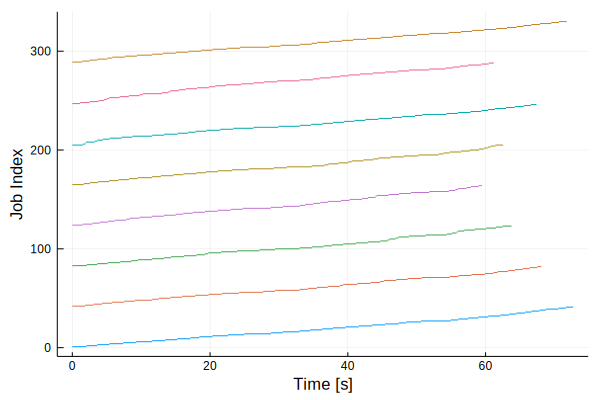

In [3]:
pmeter = Progress(windows, 5, "Computing optimal haplotype pairs...")
redundant_haplotypes = [[Tuple{Int32, Int32}[] for i in 1:windows] for j in 1:people]
[[sizehint!(redundant_haplotypes[j][i], 1000) for i in 1:windows] for j in 1:people] # don't save >1000 redundant happairs
num_unique_haps = 0
mutex = Threads.SpinLock()
pool = ThreadPools.@logthreads for w in 1:windows
    Hw_aligned = compressed_Hunique.CW_typed[w].uniqueH
    Xw_idx_start = (w - 1) * width + 1
    Xw_idx_end = (w == windows ? length(X_pos) : w * width)
    Xw_aligned = X[Xw_idx_start:Xw_idx_end, :]

    # computational routine
    if !isnothing(thinning_factor)
        happairs, hapscore, t1, t2, t3 = haplopair_thin(Xw_aligned, Hw_aligned, keep=thinning_factor)
    elseif rescreen
        happairs, hapscore, t1, t2, t3 = haplopair_screen(Xw_aligned, Hw_aligned)
    else
        happairs, hapscore, t1, t2, t3 = haplopair(Xw_aligned, Hw_aligned)
    end

    # convert happairs (which index off unique haplotypes) to indices of full haplotype pool, and find all matching happairs
    t4 = @elapsed compute_redundant_haplotypes!(redundant_haplotypes, compressed_Hunique, happairs, w)

    # update progress
    next!(pmeter)
end
avg_num_unique_haps = sum(num_unique_haps) / windows

using Plots
plot(pool)

In [8]:
x = plot(pool)
savefig(x, "logthreads.png")

### ThreadPools.@qthreads

Computing optimal haplotype pairs...100%|███████████████| Time: 0:01:19


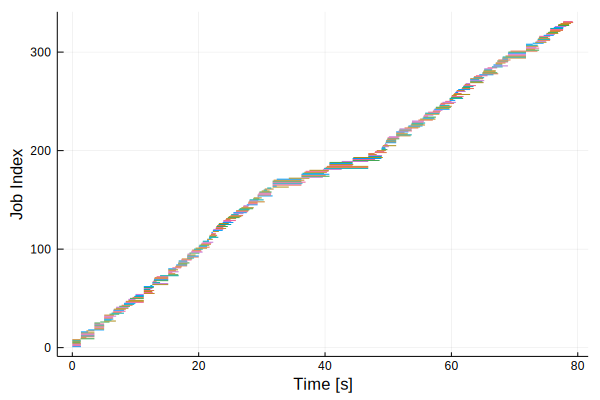

In [4]:
pmeter = Progress(windows, 5, "Computing optimal haplotype pairs...")
redundant_haplotypes = [[Tuple{Int32, Int32}[] for i in 1:windows] for j in 1:people]
[[sizehint!(redundant_haplotypes[j][i], 1000) for i in 1:windows] for j in 1:people] # don't save >1000 redundant happairs
num_unique_haps = 0
mutex = Threads.SpinLock()
pool = ThreadPools.@logqthreads for w in 1:windows
    Hw_aligned = compressed_Hunique.CW_typed[w].uniqueH
    Xw_idx_start = (w - 1) * width + 1
    Xw_idx_end = (w == windows ? length(X_pos) : w * width)
    Xw_aligned = X[Xw_idx_start:Xw_idx_end, :]

    # computational routine
    if !isnothing(thinning_factor)
        happairs, hapscore, t1, t2, t3 = haplopair_thin(Xw_aligned, Hw_aligned, keep=thinning_factor)
    elseif rescreen
        happairs, hapscore, t1, t2, t3 = haplopair_screen(Xw_aligned, Hw_aligned)
    else
        happairs, hapscore, t1, t2, t3 = haplopair(Xw_aligned, Hw_aligned)
    end

    # convert happairs (which index off unique haplotypes) to indices of full haplotype pool, and find all matching happairs
    t4 = @elapsed compute_redundant_haplotypes!(redundant_haplotypes, compressed_Hunique, happairs, w)

    # update progress
    next!(pmeter)
end
avg_num_unique_haps = sum(num_unique_haps) / windows

using Plots
plot(pool)

In [5]:
x = plot(pool)
savefig(x, "logqthreads.png")